In [12]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import re

In [26]:
# Read dataframes (adjust paths if needed)
base_path = '.'
# booknow booking has 'show_datetime' column
booknow_booking = pd.read_csv(f'{base_path}/booknow_booking/booknow_booking.csv', parse_dates=['show_datetime'])
booknow_theaters = pd.read_csv(f'{base_path}/booknow_theaters/booknow_theaters.csv')
booknow_visits = pd.read_csv(f'{base_path}/booknow_visits/booknow_visits.csv', parse_dates=['show_date'])
cinePOS_booking = pd.read_csv(f'{base_path}/cinePOS_booking/cinePOS_booking.csv')
cinePOS_theaters = pd.read_csv(f'{base_path}/cinePOS_theaters/cinePOS_theaters.csv')
movie_theater_relation = pd.read_csv(f'{base_path}/movie_theater_id_relation/movie_theater_id_relation.csv')
date_info = pd.read_csv(f'{base_path}/date_info/date_info.csv', parse_dates=['show_date'])
sample_submission = pd.read_csv(f'{base_path}/sample_submission/sample_submission.csv')
# Quick sanity prints
print('booknow_booking', booknow_booking.shape)
print('booknow_theaters', booknow_theaters.shape)
print('cinePOS_theaters', cinePOS_theaters.shape)
print('sample_submission', sample_submission.shape)

booknow_booking (68336, 4)
booknow_theaters (829, 5)
cinePOS_theaters (4690, 5)
sample_submission (38062, 2)


In [14]:
# Inspect cinePOS_theaters schema and dtypes
print('columns:', cinePOS_theaters.columns.tolist())
print('\ndtypes:\n', cinePOS_theaters.dtypes)
print('\nobject-type columns:', cinePOS_theaters.select_dtypes(include=['object']).columns.tolist())
print('\nshape:', cinePOS_theaters.shape)

columns: ['cine_theater_id', 'theater_type', 'theater_area', 'latitude', 'longitude']

dtypes:
 cine_theater_id     object
theater_type        object
theater_area        object
latitude           float64
longitude          float64
dtype: object

object-type columns: ['cine_theater_id', 'theater_type', 'theater_area']

shape: (4690, 5)


In [15]:
# Q1: What is the shape of the dataset named booknow_booking?
booknow_booking.shape  # (rows, columns)

(68336, 4)

In [16]:
# Q2: How many columns are of type Object in cinePOS_theaters?
cinePOS_theaters.select_dtypes(include=['object']).shape[1]

3

In [17]:
# Q3: Which theater type is most frequent in booknow_theaters? (Action/Comedy/Drama/Other)
theater_type_counts = booknow_theaters['theater_type'].value_counts()
print('Theater type frequency:')
print(theater_type_counts)
print(f'\nMost frequent theater type: {theater_type_counts.idxmax()}')

Theater type frequency:
theater_type
Other     411
Comedy    196
Drama     183
Action     39
Name: count, dtype: int64

Most frequent theater type: Other


In [18]:
# Q4: How many distinct theaters are present in cinePOS_booking?
# detect id-like column(s) and compute unique count
id_cols = [c for c in cinePOS_booking.columns if 'theater' in c.lower() or 'theatre' in c.lower() or 'cine' in c.lower()]
id_cols, (int(cinePOS_booking[id_cols[0]].nunique()) if len(id_cols)>0 else cinePOS_booking.shape[0])

(['cine_theater_id'], 13161)

In [19]:
# Q5: Combine booknow_booking and booknow_theaters (inner join) and report shape
combined = pd.merge(booknow_booking, booknow_theaters, on='book_theater_id', how='inner')
combined.shape

(36899, 8)

In [20]:
# Q6: How many distinct areas are theaters located in (based on combined dataset)?
if 'theater_area' in combined.columns:
    print('distinct areas:', combined['theater_area'].nunique())
else:
    print('theater_area column not found in combined dataframe')

distinct areas: 50


In [21]:
# Q7: Combine movie_theater_id_relation, cinePOS_booking and cinePOS_theaters and list columns with missing values
# movie_theater_relation contains mapping between book and cine ids
print('relation cols:', movie_theater_relation.columns.tolist())
# join on cine_theater_id (present in relation and cinePOS files)
joined = pd.merge(movie_theater_relation, cinePOS_booking, on='cine_theater_id', how='inner')
joined = pd.merge(joined, cinePOS_theaters, on='cine_theater_id', how='inner')
# columns that contain missing values
[c for c in joined.columns if joined[c].isna().any()]

relation cols: ['book_theater_id', 'cine_theater_id']


['latitude', 'longitude']

In [23]:
# Q8 (dates): Date range spanned in booknow_booking
min_date = booknow_booking['show_datetime'].dt.date.min()
max_date = booknow_booking['show_datetime'].dt.date.max()
print('booknow_booking date range:', min_date.strftime('%d-%m-%Y'), 'to', max_date.strftime('%d-%m-%Y'))


booknow_booking date range: 01-01-2023 to 28-02-2024


In [24]:
# Q9: Date range spanned in sample_submission (test set). IDs contain the date at the end
sample_submission['show_date'] = sample_submission['ID'].str.extract(r'_(\d{4}-\d{2}-\d{2})$')[0]
sample_submission['show_date'] = pd.to_datetime(sample_submission['show_date'])
min_t = sample_submission['show_date'].dt.date.min()
max_t = sample_submission['show_date'].dt.date.max()
print('sample_submission date range:', min_t.strftime('%d-%m-%Y'), 'to', max_t.strftime('%d-%m-%Y'))

sample_submission date range: 01-03-2024 to 22-04-2024


# Exploratory Data Analysis (EDA)

Now let's perform comprehensive EDA to understand the data patterns, distributions, and relationships.

In [27]:
# Data profiling and basic statistics
print("=== BOOKNOW VISITS DATA PROFILING ===")
print(f"Shape: {booknow_visits.shape}")
print(f"Date range: {booknow_visits['show_date'].min()} to {booknow_visits['show_date'].max()}")
print(f"Unique theaters: {booknow_visits['book_theater_id'].nunique()}")
print(f"Missing values:\n{booknow_visits.isnull().sum()}")
print(f"\nAudience count statistics:")
print(booknow_visits['audience_count'].describe())

print("\n=== THEATER TYPE DISTRIBUTION ===")
print(booknow_theaters['theater_type'].value_counts())
print(f"\nTheater areas: {booknow_theaters['theater_area'].nunique()} unique areas")

print("\n=== BOOKING PATTERNS ===")
print(f"BookNow bookings: {booknow_booking.shape[0]:,} records")
print(f"CinePOS bookings: {cinePOS_booking.shape[0]:,} records")
print(f"Average tickets per BookNow booking: {booknow_booking['tickets_booked'].mean():.2f}")
print(f"Average tickets per CinePOS booking: {cinePOS_booking['tickets_sold'].mean():.2f}")

=== BOOKNOW VISITS DATA PROFILING ===
Shape: (214046, 3)
Date range: 2023-01-01 00:00:00 to 2024-02-28 00:00:00
Unique theaters: 826
Missing values:
book_theater_id    0
show_date          0
audience_count     0
dtype: int64

Audience count statistics:
count    214046.000000
mean         41.616568
std          32.834918
min           2.000000
25%          18.000000
50%          34.000000
75%          58.000000
max        1350.000000
Name: audience_count, dtype: float64

=== THEATER TYPE DISTRIBUTION ===
theater_type
Other     411
Comedy    196
Drama     183
Action     39
Name: count, dtype: int64

Theater areas: 103 unique areas

=== BOOKING PATTERNS ===
BookNow bookings: 68,336 records
CinePOS bookings: 1,641,966 records
Average tickets per BookNow booking: 4.43
Average tickets per CinePOS booking: 4.99


# Data Visualization

Let's create visualizations to understand temporal patterns, geographic distribution, and booking behaviors.

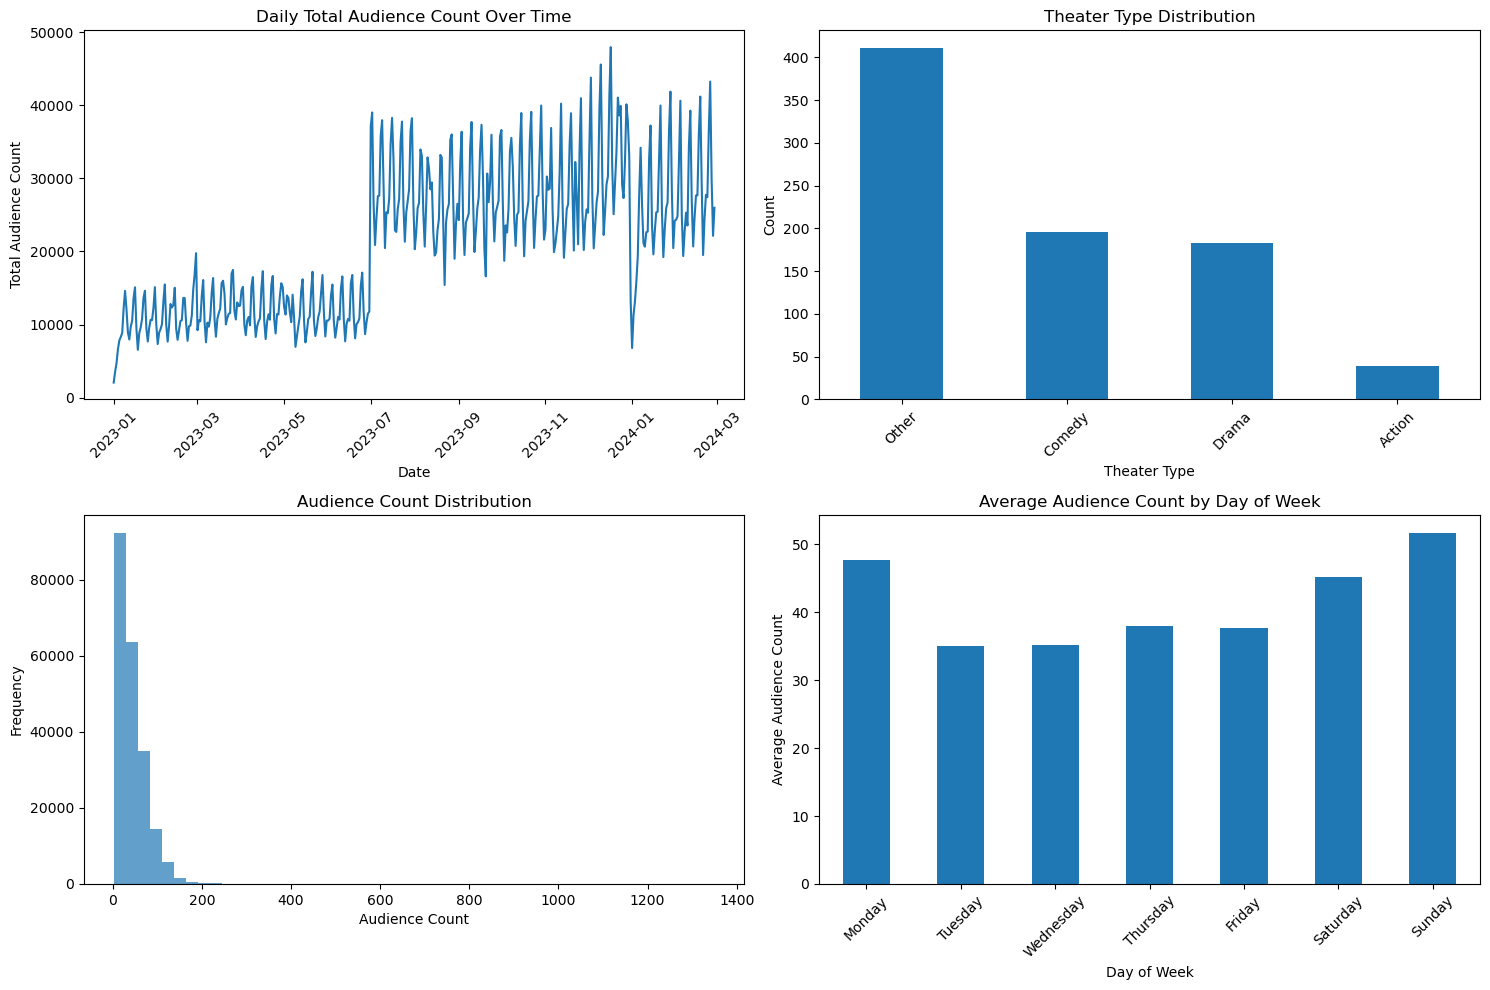

In [28]:
# Time series visualization
plt.figure(figsize=(15, 10))

# 1. Daily audience count over time
plt.subplot(2, 2, 1)
daily_audience = booknow_visits.groupby('show_date')['audience_count'].sum().reset_index()
plt.plot(daily_audience['show_date'], daily_audience['audience_count'])
plt.title('Daily Total Audience Count Over Time')
plt.xlabel('Date')
plt.ylabel('Total Audience Count')
plt.xticks(rotation=45)

# 2. Theater type distribution
plt.subplot(2, 2, 2)
theater_type_counts.plot(kind='bar')
plt.title('Theater Type Distribution')
plt.xlabel('Theater Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 3. Audience count distribution
plt.subplot(2, 2, 3)
plt.hist(booknow_visits['audience_count'], bins=50, alpha=0.7)
plt.title('Audience Count Distribution')
plt.xlabel('Audience Count')
plt.ylabel('Frequency')

# 4. Booking patterns by day of week
plt.subplot(2, 2, 4)
booknow_visits['day_of_week'] = booknow_visits['show_date'].dt.day_name()
daily_avg = booknow_visits.groupby('day_of_week')['audience_count'].mean()
# Reorder to start with Monday
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = daily_avg.reindex(days_order)
daily_avg.plot(kind='bar')
plt.title('Average Audience Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Audience Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

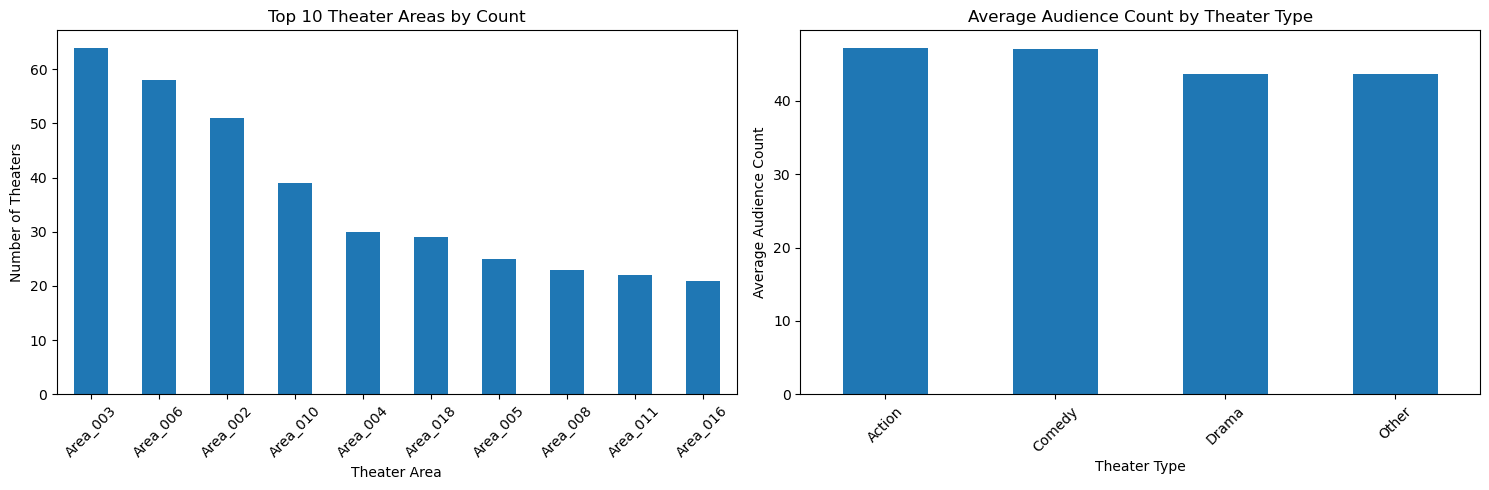

In [29]:
# Geographic and theater analysis
plt.figure(figsize=(15, 5))

# 1. Theater area distribution
plt.subplot(1, 2, 1)
area_counts = booknow_theaters['theater_area'].value_counts().head(10)
area_counts.plot(kind='bar')
plt.title('Top 10 Theater Areas by Count')
plt.xlabel('Theater Area')
plt.ylabel('Number of Theaters')
plt.xticks(rotation=45)

# 2. Audience count by theater type
plt.subplot(1, 2, 2)
# Merge visits with theater info to get theater type
visits_with_type = booknow_visits.merge(booknow_theaters[['book_theater_id', 'theater_type']], on='book_theater_id', how='left')
type_audience = visits_with_type.groupby('theater_type')['audience_count'].mean()
type_audience.plot(kind='bar')
plt.title('Average Audience Count by Theater Type')
plt.xlabel('Theater Type')
plt.ylabel('Average Audience Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Statistical Analysis

Let's analyze trends, seasonality, and correlations in the data.

=== CORRELATION ANALYSIS ===


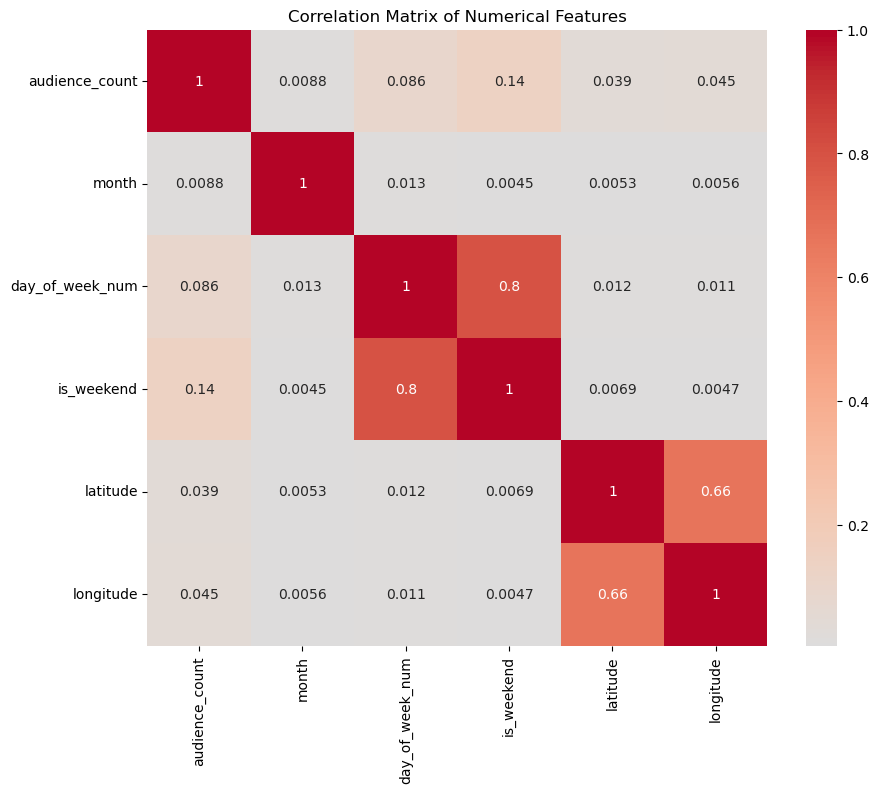

\n=== STATISTICAL TESTS ===
Weekend vs Weekday audience t-test: t=65.519, p=0.000e+00
Weekend mean: 48.4, Weekday mean: 38.5
\nMonthly audience statistics:
            mean        std  count
month                             
1      39.953516  32.325016  27020
2      40.955389  31.079722  27415
3      45.733752  35.086688   8278
4      45.066634  34.508441   8089
5      44.018625  34.685006   8161
6      42.639020  32.994220   8247
7      42.535306  33.559453  21427
8      39.496977  31.870239  20675
9      39.816890  30.689974  20829
10     40.639430  31.510851  21466
11     39.503250  31.664138  20924
12     46.257681  36.884003  21515
Weekend vs Weekday audience t-test: t=65.519, p=0.000e+00
Weekend mean: 48.4, Weekday mean: 38.5
\nMonthly audience statistics:
            mean        std  count
month                             
1      39.953516  32.325016  27020
2      40.955389  31.079722  27415
3      45.733752  35.086688   8278
4      45.066634  34.508441   8089
5      44.018625

In [30]:
# Statistical analysis and correlations
from scipy import stats
import seaborn as sns

# Correlation analysis
print("=== CORRELATION ANALYSIS ===")
# Create a dataset with numerical features
visits_enhanced = booknow_visits.merge(booknow_theaters, on='book_theater_id', how='left')
visits_enhanced['month'] = visits_enhanced['show_date'].dt.month
visits_enhanced['day_of_week_num'] = visits_enhanced['show_date'].dt.dayofweek
visits_enhanced['is_weekend'] = visits_enhanced['day_of_week_num'].isin([5, 6]).astype(int)

# Calculate correlations
numeric_cols = ['audience_count', 'month', 'day_of_week_num', 'is_weekend', 'latitude', 'longitude']
corr_matrix = visits_enhanced[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Statistical tests
print("\\n=== STATISTICAL TESTS ===")
# Test for weekend effect
weekend_audience = visits_enhanced[visits_enhanced['is_weekend'] == 1]['audience_count']
weekday_audience = visits_enhanced[visits_enhanced['is_weekend'] == 0]['audience_count']
t_stat, p_value = stats.ttest_ind(weekend_audience, weekday_audience)
print(f"Weekend vs Weekday audience t-test: t={t_stat:.3f}, p={p_value:.3e}")
print(f"Weekend mean: {weekend_audience.mean():.1f}, Weekday mean: {weekday_audience.mean():.1f}")

# Monthly seasonality analysis
monthly_stats = visits_enhanced.groupby('month')['audience_count'].agg(['mean', 'std', 'count'])
print(f"\\nMonthly audience statistics:")
print(monthly_stats)

# Train-Validation Split

For time series forecasting, we need to use time-based splitting to avoid data leakage.

=== TRAIN-VALIDATION SPLIT ===
Data spans from 2023-01-01 00:00:00 to 2024-02-28 00:00:00
Split date: 2023-12-05 00:00:00
Training period: 2023-01-01 00:00:00 to 2023-12-05 00:00:00
Validation period: 2023-12-06 00:00:00 to 2024-02-28 00:00:00
\nTraining set: 156,529 records
Validation set: 57,517 records


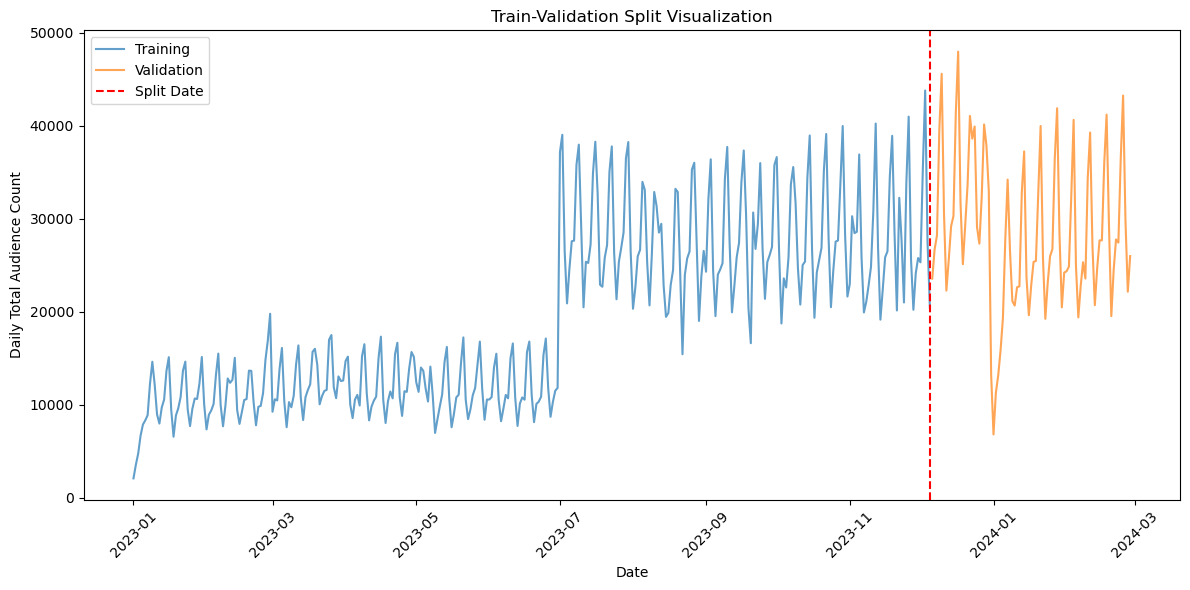

In [31]:
# Time-based train-validation split
print("=== TRAIN-VALIDATION SPLIT ===")

# Get the full date range
min_date = booknow_visits['show_date'].min()
max_date = booknow_visits['show_date'].max()
print(f"Data spans from {min_date} to {max_date}")

# Use 80% for training, 20% for validation (time-based)
total_days = (max_date - min_date).days
train_days = int(total_days * 0.8)
split_date = min_date + pd.Timedelta(days=train_days)

print(f"Split date: {split_date}")
print(f"Training period: {min_date} to {split_date}")
print(f"Validation period: {split_date + pd.Timedelta(days=1)} to {max_date}")

# Create train and validation sets
train_visits = booknow_visits[booknow_visits['show_date'] <= split_date].copy()
val_visits = booknow_visits[booknow_visits['show_date'] > split_date].copy()

print(f"\\nTraining set: {len(train_visits):,} records")
print(f"Validation set: {len(val_visits):,} records")

# Visualize the split
plt.figure(figsize=(12, 6))
daily_train = train_visits.groupby('show_date')['audience_count'].sum()
daily_val = val_visits.groupby('show_date')['audience_count'].sum()

plt.plot(daily_train.index, daily_train.values, label='Training', alpha=0.7)
plt.plot(daily_val.index, daily_val.values, label='Validation', alpha=0.7)
plt.axvline(x=split_date, color='red', linestyle='--', label='Split Date')
plt.title('Train-Validation Split Visualization')
plt.xlabel('Date')
plt.ylabel('Daily Total Audience Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Cleaning and Preprocessing

Let's create a comprehensive feature engineering pipeline for the forecasting model.

In [43]:
# Feature engineering function
def create_features(visits_df, bookings_df, theaters_df, date_info_df):
    """
    Create comprehensive features for forecasting model
    """
    # Start with visits data
    features_df = visits_df.copy()
    
    # Merge with theater information
    features_df = features_df.merge(theaters_df, on='book_theater_id', how='left')
    
    # Date-based features
    features_df['year'] = features_df['show_date'].dt.year
    features_df['month'] = features_df['show_date'].dt.month
    features_df['day'] = features_df['show_date'].dt.day
    features_df['day_of_week'] = features_df['show_date'].dt.dayofweek
    features_df['is_weekend'] = features_df['day_of_week'].isin([5, 6]).astype(int)
    features_df['week_of_year'] = features_df['show_date'].dt.isocalendar().week
    
    # Calendar-based features from date_info if available (avoid column conflicts)
    if len(date_info_df) > 0 and 'show_date' in date_info_df.columns:
        # Select only useful columns that don't conflict
        useful_cols = ['show_date'] + [col for col in date_info_df.columns 
                                      if col not in ['show_date', 'day_of_week']]
        if useful_cols:
            date_features = date_info_df[useful_cols].copy()
            features_df = features_df.merge(date_features, on='show_date', how='left')
    
    # Lag features (previous audience counts)
    features_df = features_df.sort_values(['book_theater_id', 'show_date'])
    for lag in [1, 7, 14]:  # 1 day, 1 week, 2 weeks
        features_df[f'audience_lag_{lag}'] = features_df.groupby('book_theater_id')['audience_count'].shift(lag)
    
    # Rolling averages
    for window in [7, 14, 30]:  # 1 week, 2 weeks, 1 month
        features_df[f'audience_rolling_mean_{window}'] = (
            features_df.groupby('book_theater_id')['audience_count']
            .rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)
        )
    
    # Theater-specific features
    theater_stats = features_df.groupby('book_theater_id')['audience_count'].agg([
        'mean', 'std', 'min', 'max'
    ]).add_prefix('theater_')
    features_df = features_df.merge(theater_stats, on='book_theater_id', how='left')
    
    # Encode categorical variables
    from sklearn.preprocessing import LabelEncoder
    le_theater_type = LabelEncoder()
    le_theater_area = LabelEncoder()
    
    features_df['theater_type_encoded'] = le_theater_type.fit_transform(features_df['theater_type'].fillna('Unknown'))
    features_df['theater_area_encoded'] = le_theater_area.fit_transform(features_df['theater_area'].fillna('Unknown'))
    
    return features_df, le_theater_type, le_theater_area

# Apply feature engineering
print("=== FEATURE ENGINEERING ===")
train_features, le_type, le_area = create_features(train_visits, booknow_booking, booknow_theaters, date_info)
val_features, _, _ = create_features(val_visits, booknow_booking, booknow_theaters, date_info)

print(f"Training features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Feature columns: {train_features.columns.tolist()}")

# Check which columns actually exist for modeling
available_feature_cols = [
    'year', 'month', 'day', 'day_of_week', 'is_weekend', 'week_of_year',
    'theater_type_encoded', 'theater_area_encoded', 'latitude', 'longitude',
    'audience_lag_1', 'audience_lag_7', 'audience_lag_14',
    'audience_rolling_mean_7', 'audience_rolling_mean_14', 'audience_rolling_mean_30',
    'theater_mean', 'theater_std', 'theater_min', 'theater_max'
]

# Filter to only use columns that actually exist
feature_cols = [col for col in available_feature_cols if col in train_features.columns]
print(f"\\nFeatures to use for modeling: {feature_cols}")

=== FEATURE ENGINEERING ===
Training features shape: (156529, 25)
Validation features shape: (57517, 25)
Feature columns: ['book_theater_id', 'show_date', 'audience_count', 'day_of_week', 'theater_type', 'theater_area', 'latitude', 'longitude', 'year', 'month', 'day', 'is_weekend', 'week_of_year', 'audience_lag_1', 'audience_lag_7', 'audience_lag_14', 'audience_rolling_mean_7', 'audience_rolling_mean_14', 'audience_rolling_mean_30', 'theater_mean', 'theater_std', 'theater_min', 'theater_max', 'theater_type_encoded', 'theater_area_encoded']
\nFeatures to use for modeling: ['year', 'month', 'day', 'day_of_week', 'is_weekend', 'week_of_year', 'theater_type_encoded', 'theater_area_encoded', 'latitude', 'longitude', 'audience_lag_1', 'audience_lag_7', 'audience_lag_14', 'audience_rolling_mean_7', 'audience_rolling_mean_14', 'audience_rolling_mean_30', 'theater_mean', 'theater_std', 'theater_min', 'theater_max']
Training features shape: (156529, 25)
Validation features shape: (57517, 25)
Fea

# Baseline Model

Let's build a baseline forecasting model using XGBoost (alternative to LightGBM for easier installation).

In [44]:
# Baseline model using XGBoost (alternative to LightGBM)
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Use the feature_cols determined in the previous cell
print(f"Using {len(feature_cols)} features for modeling: {feature_cols}")

# Remove rows with NaN values (due to lag features)
train_clean = train_features.dropna(subset=feature_cols + ['audience_count'])
val_clean = val_features.dropna(subset=feature_cols + ['audience_count'])

X_train = train_clean[feature_cols]
y_train = train_clean['audience_count']
X_val = val_clean[feature_cols]
y_val = val_clean['audience_count']

print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

# Train XGBoost model
print("\\n=== TRAINING BASELINE MODEL (XGBoost) ===")
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'random_state': 42,
    'verbosity': 0
}

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train model with early stopping
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=100
)

# Make predictions
train_pred = model.predict(dtrain, iteration_range=(0, model.best_iteration))
val_pred = model.predict(dval, iteration_range=(0, model.best_iteration))

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
val_mae = mean_absolute_error(y_val, val_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"\\n=== MODEL PERFORMANCE ===")
print(f"Training MAE: {train_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")

# Feature importance
feature_importance = model.get_score(importance_type='gain')
# Convert to list in same order as feature_cols
importance_values = [feature_importance.get(f'f{i}', 0) for i in range(len(feature_cols))]
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance_values
}).sort_values('importance', ascending=False)

print(f"\\nTop 10 Most Important Features:")
print(importance_df.head(10))

Using 20 features for modeling: ['year', 'month', 'day', 'day_of_week', 'is_weekend', 'week_of_year', 'theater_type_encoded', 'theater_area_encoded', 'latitude', 'longitude', 'audience_lag_1', 'audience_lag_7', 'audience_lag_14', 'audience_rolling_mean_7', 'audience_rolling_mean_14', 'audience_rolling_mean_30', 'theater_mean', 'theater_std', 'theater_min', 'theater_max']
Training samples: 53,633
Validation samples: 17,829
\n=== TRAINING BASELINE MODEL (XGBoost) ===
[0]	train-mae:24.84088	val-mae:25.54603
[100]	train-mae:14.43535	val-mae:15.86283
[100]	train-mae:14.43535	val-mae:15.86283
[147]	train-mae:14.08470	val-mae:15.96593
[147]	train-mae:14.08470	val-mae:15.96593
\n=== MODEL PERFORMANCE ===
Training MAE: 14.47
Validation MAE: 15.86
Training RMSE: 20.44
Validation RMSE: 23.28
\nTop 10 Most Important Features:
                feature  importance
0                  year           0
1                 month           0
2                   day           0
3           day_of_week       

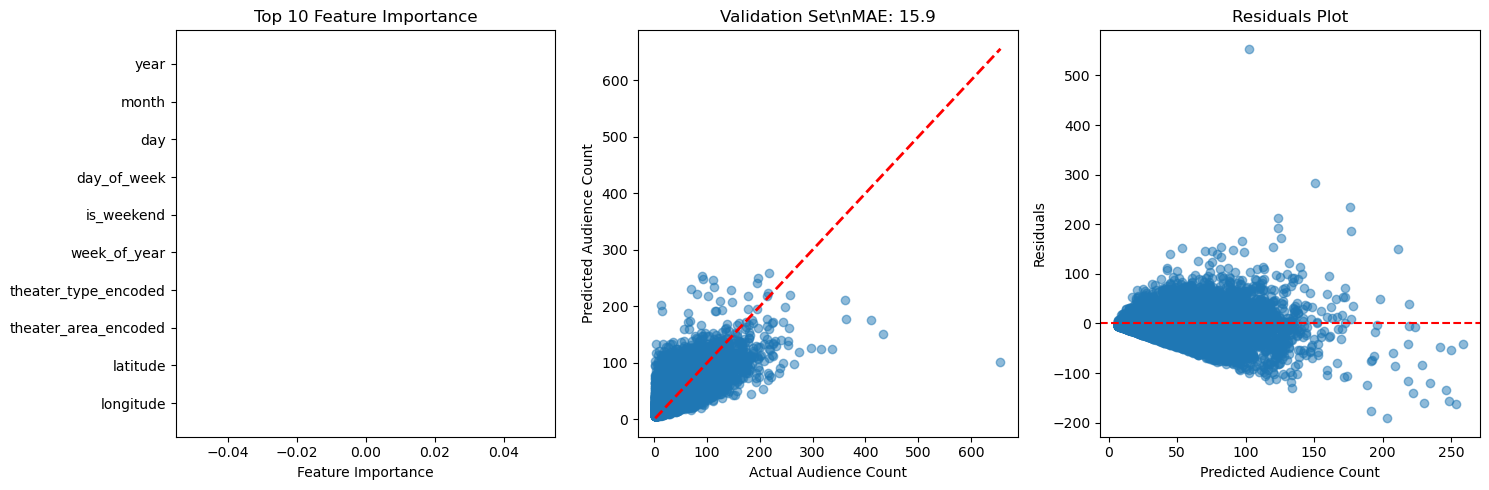

\n=== SAVING MODEL ===
Model saved to cinema_audience_baseline_model.pkl
\n=== MODEL SUMMARY ===
Baseline XGBoost Model Performance:
- Validation MAE: 15.86
- Validation RMSE: 23.28
- Number of features: 20
- Best iteration: 98
\nModel ready for submission predictions!
\nPrediction function 'predict_audience' created for making predictions on new data.


In [45]:
# Model evaluation and visualization
plt.figure(figsize=(15, 5))

# 1. Feature importance plot
plt.subplot(1, 3, 1)
top_features = importance_df.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()

# 2. Predictions vs Actual (validation set)
plt.subplot(1, 3, 2)
plt.scatter(y_val, val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Audience Count')
plt.ylabel('Predicted Audience Count')
plt.title(f'Validation Set\\nMAE: {val_mae:.1f}')

# 3. Residuals plot
plt.subplot(1, 3, 3)
residuals = y_val - val_pred
plt.scatter(val_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Audience Count')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

plt.tight_layout()
plt.show()

# Save the model
print("\\n=== SAVING MODEL ===")
model_path = 'cinema_audience_baseline_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump({
        'model': model,
        'feature_cols': feature_cols,
        'le_theater_type': le_type,
        'le_theater_area': le_area,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'best_iteration': model.best_iteration
    }, f)
print(f"Model saved to {model_path}")

print(f"\\n=== MODEL SUMMARY ===")
print(f"Baseline XGBoost Model Performance:")
print(f"- Validation MAE: {val_mae:.2f}")
print(f"- Validation RMSE: {val_rmse:.2f}")
print(f"- Number of features: {len(feature_cols)}")
print(f"- Best iteration: {model.best_iteration}")
print(f"\\nModel ready for submission predictions!")

# Additional: Create a simple prediction function for new data
def predict_audience(model, feature_cols, new_data):
    """
    Function to make predictions on new data
    """
    new_dmatrix = xgb.DMatrix(new_data[feature_cols])
    predictions = model.predict(new_dmatrix, iteration_range=(0, model.best_iteration))
    return predictions

print("\\nPrediction function 'predict_audience' created for making predictions on new data.")